# Import


In [1]:
pip install pandas_ta transformers --quiet


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import time
import math
import numpy as np
import pandas as pd
import torch
import pandas_ta as ta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Reading the data and cleaning

In [3]:
apple_df = pd.read_csv('./AAPL.csv')
print("Apple DataFrame:")
print(apple_df.head())

Apple DataFrame:
         Date      Open      High       Low     Close  Adj Close     Volume
0  1980-12-12  0.513393  0.515625  0.513393  0.513393   0.406782  117258400
1  1980-12-15  0.488839  0.488839  0.486607  0.486607   0.385558   43971200
2  1980-12-16  0.453125  0.453125  0.450893  0.450893   0.357260   26432000
3  1980-12-17  0.462054  0.464286  0.462054  0.462054   0.366103   21610400
4  1980-12-18  0.475446  0.477679  0.475446  0.475446   0.376715   18362400


In [4]:
''' Add 2 indexes RSI e EMAS and set the label column, drop the null values and reset the index'''
apple_df['RSI']=ta.rsi(apple_df.Close, length=15)
apple_df['EMAS']=ta.ema(apple_df.Close, length=150)

apple_df['TargetNextClose'] = apple_df['Close'].shift(-1)
#apple_df['Target'] = apple_df['Adj Close'] - apple_df.Open
#apple_df['Target'] = apple_df['Target'].shift(-1)


apple_df.dropna(inplace=True)
apple_df.reset_index(inplace = True)

apple_df.head()

,index,Date,Open,High,Low,Close,Adj Close,Volume,RSI,EMAS,TargetNextClose
0,149,1981-07-17,0.462054,0.464286,0.462054,0.462054,0.366103,4956000,45.489888,0.503750,0.430804
1,150,1981-07-20,0.433036,0.433036,0.430804,0.430804,0.341343,5913600,39.340144,0.502784,0.428571
2,151,1981-07-21,0.430804,0.430804,0.428571,0.428571,0.339574,7985600,38.937296,0.501801,0.404018
3,152,1981-07-22,0.408482,0.408482,0.404018,0.404018,0.320119,5667200,34.744109,0.500506,0.415179
4,153,1981-07-23,0.415179,0.417411,0.415179,0.415179,0.328962,8612800,37.996016,0.499376,0.428571


In [5]:
''' take only the columns of interest'''
dataset = apple_df.iloc[:, 2:11]
pd.set_option('display.max_columns', None)
dataset.head()
#dataset.shape

,Open,High,Low,Close,Adj Close,Volume,RSI,EMAS,TargetNextClose
0,0.462054,0.464286,0.462054,0.462054,0.366103,4956000,45.489888,0.503750,0.430804
1,0.433036,0.433036,0.430804,0.430804,0.341343,5913600,39.340144,0.502784,0.428571
2,0.430804,0.430804,0.428571,0.428571,0.339574,7985600,38.937296,0.501801,0.404018
3,0.408482,0.408482,0.404018,0.404018,0.320119,5667200,34.744109,0.500506,0.415179
4,0.415179,0.417411,0.415179,0.415179,0.328962,8612800,37.996016,0.499376,0.428571


In [6]:
'''take the close column and apply the scaler '''
price = dataset[['Close']]
price = price.tail(5000)
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

# Split the data

In [7]:
def split_data(stock, lookback):
    ''' split the data into train and test both the label and data to insert in the model with 20 days of sequence'''
    data_raw = stock.to_numpy() # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]

lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [8]:
''' create the tensors'''
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

# Base case with moving average

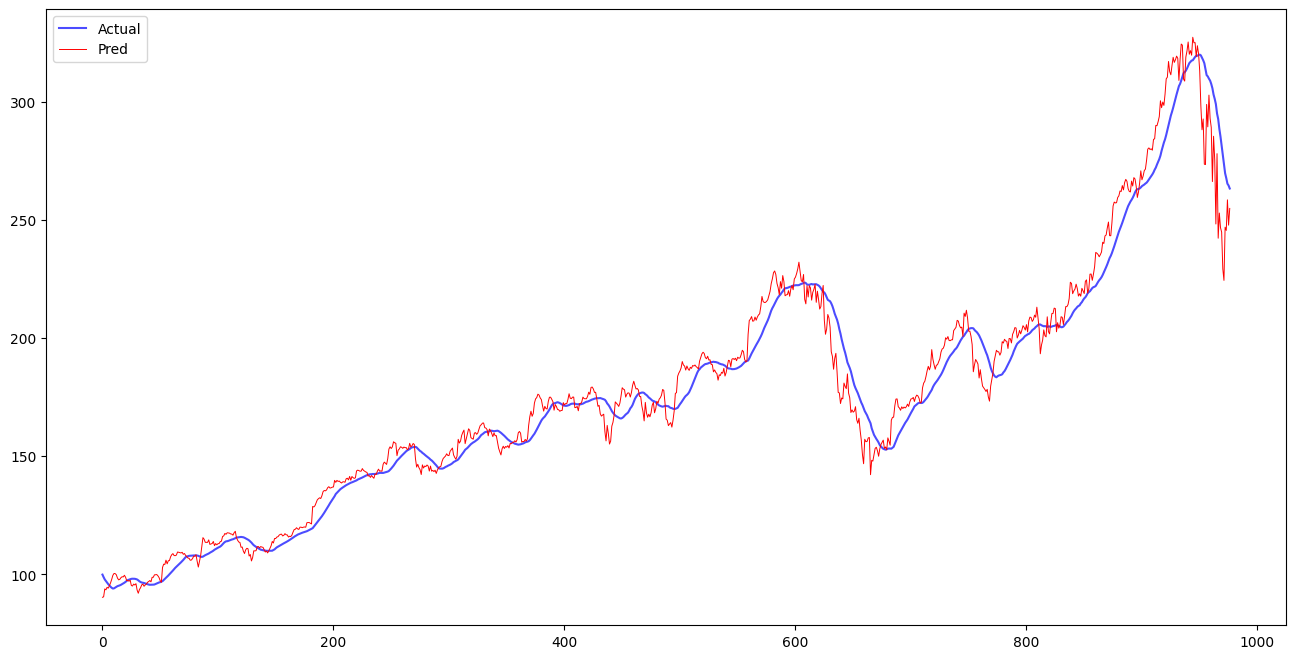

In [9]:
def moving_average(data, window_size):
    '''calculate the base line by using the moving average and plot the result'''
    moving_averages = []
    for i in range(len(data) - window_size + 1):
        window = data[i:i + window_size]
        average = sum(window) / window_size
        moving_averages.append(average)
    return moving_averages

r=[]

result = moving_average(x_test, lookback)
for i in range(len(result)):
  r.append(result[i][18])

last_values = y_test_lstm[-977:]

p = scaler.inverse_transform(last_values)
true = scaler.inverse_transform(r)

plt.figure(figsize=(16,8))
plt.plot(true, color='blue', alpha=0.7, label = 'Actual')
plt.plot(p, color='red', linewidth=0.7, label = 'Pred')
plt.legend()
plt.show()

# LSTM

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [11]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 900
model_lstm = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.01)

C:\Users\fabio\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [266]:
los = np.zeros(num_epochs)
start_time = time.time()
b = 100
lstm = []
for t in range(num_epochs):
    y_train_pred = model_lstm(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    los[t] = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))
torch.save(model_lstm.state_dict(), './best_model_lstm.pth')

Epoch  0 MSE:  0.6781052350997925
Epoch  1 MSE:  0.4592916667461395
Epoch  2 MSE:  0.22659887373447418
Epoch  3 MSE:  0.04385890066623688
Epoch  4 MSE:  0.30676642060279846
Epoch  5 MSE:  0.13882113993167877
Epoch  6 MSE:  0.04761253297328949
Epoch  7 MSE:  0.057069599628448486
Epoch  8 MSE:  0.08602507412433624
Epoch  9 MSE:  0.1019461527466774
Epoch  10 MSE:  0.10220768302679062
Epoch  11 MSE:  0.09192540496587753
Epoch  12 MSE:  0.07703215628862381
Epoch  13 MSE:  0.06257069110870361
Epoch  14 MSE:  0.05209733545780182
Epoch  15 MSE:  0.04734688997268677
Epoch  16 MSE:  0.04811124503612518
Epoch  17 MSE:  0.05244031175971031
Epoch  18 MSE:  0.05738411471247673
Epoch  19 MSE:  0.06039135530591011
Epoch  20 MSE:  0.060384128242731094
Epoch  21 MSE:  0.05781436711549759
Epoch  22 MSE:  0.05400754138827324
Epoch  23 MSE:  0.05036267638206482
Epoch  24 MSE:  0.047819871455430984
Epoch  25 MSE:  0.04669849947094917
Epoch  26 MSE:  0.04680316150188446
Epoch  27 MSE:  0.04764406383037567
Ep

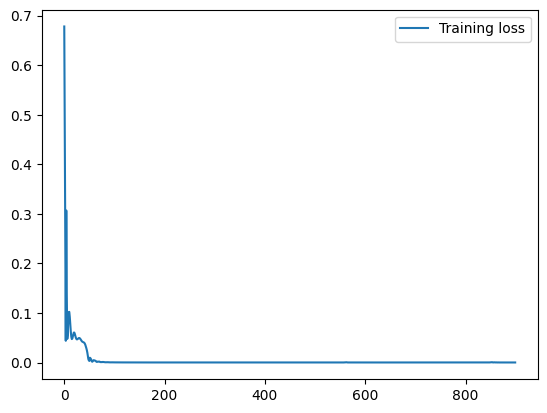

In [267]:
'''plot the train loss'''
plt.plot(los, label="Training loss")
plt.legend()
plt.show()

In [12]:
'''load the model and restore the real values , not scaled'''
model_lstm.load_state_dict(torch.load('./BEST/best_model_lstm.pth', map_location=torch.device('cpu')))
model_lstm.eval()
y_test_pred = model_lstm(x_test)
y_test_pred_np = y_test_pred.detach().numpy()
y_test_pred_np = scaler.inverse_transform(y_test_pred_np)
y_test = scaler.inverse_transform(y_test)

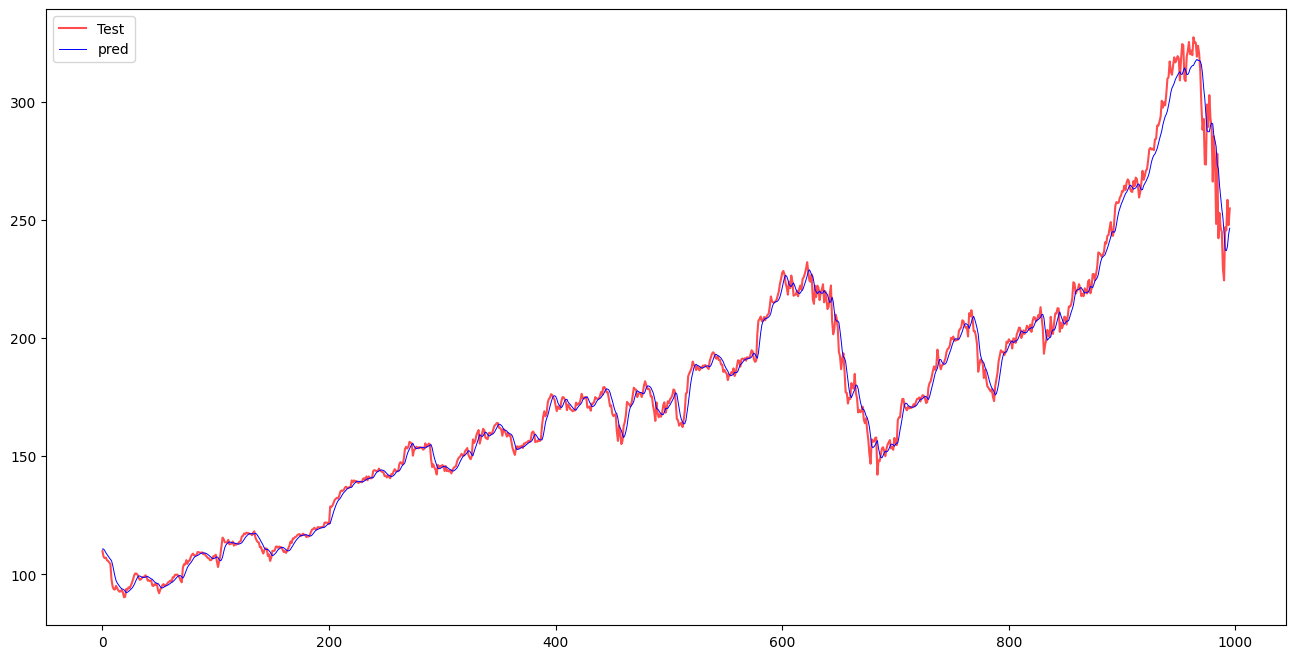

In [13]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color='red', alpha=0.7, label = 'Test')
plt.plot(y_test_pred_np, color='blue', linewidth=0.7, label = 'pred')
plt.legend()
plt.show()

# LSTM with more Data

In [14]:
'''apply the normalization to al the dataset'''
scaler_lstm = MinMaxScaler(feature_range=(0,1))
print(dataset.shape)
normalized_dataset = scaler_lstm.fit_transform(dataset)

(9759, 9)


In [15]:
'''split the data into label and create the sequence of 20 days to put into the model'''
X = []
print(normalized_dataset.shape[0])
for j in range(8):
    X.append([])
    for i in range(lookback, normalized_dataset.shape[0]):
        X[j].append(normalized_dataset[i-lookback:i, j])

#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2])

X, yi =np.array(X), np.array(normalized_dataset[lookback:,-1])
y=np.reshape(yi,(len(yi),1))

print(X.shape)
print(y.shape)

9759
(9739, 20, 8)
(9739, 1)


In [16]:
'''split the data in train and test'''
limit = int(len(X)*0.9)

X_train_l, X_test_l = X[:limit], X[limit:]
y_train_l, y_test_l = y[:limit], y[limit:]

X_train_tensor = torch.tensor(X_train_l, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_l, dtype=torch.float32).to(device)

In [17]:
''' Define the PyTorch model'''
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        return output

model = CustomLSTM(input_size=8, hidden_size=512, output_size=1).to(device)

criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters())

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
best_loss = 100

In [288]:
''' Training loop'''
num_epochs = 50
los_lstm = np.zeros(num_epochs)
for epoch in range(num_epochs):
    total_loss = 0.0
    for inputs, targets in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        optimizer.zero_grad()
        outputs = model(inputs).to(device)
        loss = criterion(outputs, targets).to(device)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    los_lstm[epoch] = total_loss
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {total_loss}')

    if total_loss < best_loss:
              best_loss = total_loss
              torch.save(model.state_dict(), './best_model_lstm_pro_prova.pth')
              print(f'Saved the model of epoch {epoch + 1}, with Loss: {total_loss}')

Epoch 1/50:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 1/50: 100%|██████████| 274/274 [00:22<00:00, 11.94it/s]


Epoch [1/50], Training Loss: 0.07478212516741678
Saved the model of epoch 1, with Loss: 0.07478212516741678


Epoch 2/50: 100%|██████████| 274/274 [00:20<00:00, 13.30it/s]


Epoch [2/50], Training Loss: 0.0037396554926090175
Saved the model of epoch 2, with Loss: 0.0037396554926090175


Epoch 3/50: 100%|██████████| 274/274 [00:23<00:00, 11.77it/s]


Epoch [3/50], Training Loss: 0.004352849535393943


Epoch 4/50: 100%|██████████| 274/274 [00:26<00:00, 10.23it/s]


Epoch [4/50], Training Loss: 0.004168062366147751


Epoch 5/50: 100%|██████████| 274/274 [00:23<00:00, 11.64it/s]


Epoch [5/50], Training Loss: 0.004964407497823231


Epoch 6/50: 100%|██████████| 274/274 [00:25<00:00, 10.67it/s]


Epoch [6/50], Training Loss: 0.004086920710165032


Epoch 7/50: 100%|██████████| 274/274 [00:23<00:00, 11.61it/s]


Epoch [7/50], Training Loss: 0.003657042659256149
Saved the model of epoch 7, with Loss: 0.003657042659256149


Epoch 8/50: 100%|██████████| 274/274 [00:24<00:00, 11.01it/s]


Epoch [8/50], Training Loss: 0.0037604767052243915


Epoch 9/50: 100%|██████████| 274/274 [00:25<00:00, 10.93it/s]


Epoch [9/50], Training Loss: 0.0036824850823791166


Epoch 10/50: 100%|██████████| 274/274 [00:25<00:00, 10.83it/s]


Epoch [10/50], Training Loss: 0.003266110364904762
Saved the model of epoch 10, with Loss: 0.003266110364904762


Epoch 11/50: 100%|██████████| 274/274 [00:21<00:00, 12.55it/s]


Epoch [11/50], Training Loss: 0.0037776737358967694


Epoch 12/50: 100%|██████████| 274/274 [00:26<00:00, 10.39it/s]


Epoch [12/50], Training Loss: 0.003569704853305211


Epoch 13/50: 100%|██████████| 274/274 [00:23<00:00, 11.49it/s]


Epoch [13/50], Training Loss: 0.0031591839651810005
Saved the model of epoch 13, with Loss: 0.0031591839651810005


Epoch 14/50: 100%|██████████| 274/274 [00:27<00:00, 10.07it/s]


Epoch [14/50], Training Loss: 0.00297776173050579
Saved the model of epoch 14, with Loss: 0.00297776173050579


Epoch 15/50: 100%|██████████| 274/274 [00:22<00:00, 12.32it/s]


Epoch [15/50], Training Loss: 0.0031666219082922


Epoch 16/50: 100%|██████████| 274/274 [00:27<00:00, 10.02it/s]


Epoch [16/50], Training Loss: 0.00336649038700898


Epoch 17/50: 100%|██████████| 274/274 [00:17<00:00, 15.80it/s]


Epoch [17/50], Training Loss: 0.002749418815142235
Saved the model of epoch 17, with Loss: 0.002749418815142235


Epoch 18/50: 100%|██████████| 274/274 [00:16<00:00, 16.34it/s]


Epoch [18/50], Training Loss: 0.0031041038852208658


Epoch 19/50: 100%|██████████| 274/274 [00:21<00:00, 12.99it/s]


Epoch [19/50], Training Loss: 0.0028587605895893375


Epoch 20/50: 100%|██████████| 274/274 [00:19<00:00, 13.79it/s]


Epoch [20/50], Training Loss: 0.0029010712321451138


Epoch 21/50: 100%|██████████| 274/274 [00:28<00:00,  9.66it/s]


Epoch [21/50], Training Loss: 0.003314437792710123


Epoch 22/50: 100%|██████████| 274/274 [00:33<00:00,  8.25it/s]


Epoch [22/50], Training Loss: 0.0029982984543721614


Epoch 23/50: 100%|██████████| 274/274 [00:27<00:00, 10.08it/s]


Epoch [23/50], Training Loss: 0.0030901443645916515


Epoch 24/50: 100%|██████████| 274/274 [00:20<00:00, 13.25it/s]


Epoch [24/50], Training Loss: 0.003006937096671436


Epoch 25/50: 100%|██████████| 274/274 [00:20<00:00, 13.37it/s]


Epoch [25/50], Training Loss: 0.002815015221642625


Epoch 26/50: 100%|██████████| 274/274 [00:20<00:00, 13.25it/s]


Epoch [26/50], Training Loss: 0.0033458825776051526


Epoch 27/50: 100%|██████████| 274/274 [00:20<00:00, 13.14it/s]


Epoch [27/50], Training Loss: 0.002516321084726769
Saved the model of epoch 27, with Loss: 0.002516321084726769


Epoch 28/50: 100%|██████████| 274/274 [00:18<00:00, 14.96it/s]


Epoch [28/50], Training Loss: 0.0028136286545077382


Epoch 29/50: 100%|██████████| 274/274 [00:20<00:00, 13.35it/s]


Epoch [29/50], Training Loss: 0.0026297383792552864


Epoch 30/50: 100%|██████████| 274/274 [00:20<00:00, 13.51it/s]


Epoch [30/50], Training Loss: 0.002691298485927973


Epoch 31/50: 100%|██████████| 274/274 [00:19<00:00, 13.70it/s]


Epoch [31/50], Training Loss: 0.0028279110580911038


Epoch 32/50: 100%|██████████| 274/274 [00:20<00:00, 13.28it/s]


Epoch [32/50], Training Loss: 0.002517613831628296


Epoch 33/50: 100%|██████████| 274/274 [00:20<00:00, 13.19it/s]


Epoch [33/50], Training Loss: 0.003027584480491896


Epoch 34/50: 100%|██████████| 274/274 [00:20<00:00, 13.30it/s]


Epoch [34/50], Training Loss: 0.0027332748921651273


Epoch 35/50: 100%|██████████| 274/274 [00:20<00:00, 13.10it/s]


Epoch [35/50], Training Loss: 0.00244770778007819
Saved the model of epoch 35, with Loss: 0.00244770778007819


Epoch 36/50: 100%|██████████| 274/274 [00:21<00:00, 12.64it/s]


Epoch [36/50], Training Loss: 0.0029859112042913694


Epoch 37/50: 100%|██████████| 274/274 [00:21<00:00, 13.03it/s]


Epoch [37/50], Training Loss: 0.0026615688922220215


Epoch 38/50: 100%|██████████| 274/274 [00:18<00:00, 14.56it/s]


Epoch [38/50], Training Loss: 0.0026292455907821477


Epoch 39/50: 100%|██████████| 274/274 [00:19<00:00, 13.78it/s]


Epoch [39/50], Training Loss: 0.0024929656260042066


Epoch 40/50: 100%|██████████| 274/274 [00:20<00:00, 13.18it/s]


Epoch [40/50], Training Loss: 0.0027801938004472504


Epoch 41/50: 100%|██████████| 274/274 [00:21<00:00, 12.87it/s]


Epoch [41/50], Training Loss: 0.0025335572482845237


Epoch 42/50: 100%|██████████| 274/274 [00:20<00:00, 13.19it/s]


Epoch [42/50], Training Loss: 0.0028363081831912496


Epoch 43/50: 100%|██████████| 274/274 [00:20<00:00, 13.12it/s]


Epoch [43/50], Training Loss: 0.0026263603075449282


Epoch 44/50: 100%|██████████| 274/274 [00:20<00:00, 13.08it/s]


Epoch [44/50], Training Loss: 0.0026137958915626314


Epoch 45/50: 100%|██████████| 274/274 [00:23<00:00, 11.69it/s]


Epoch [45/50], Training Loss: 0.00280862187838693


Epoch 46/50: 100%|██████████| 274/274 [00:19<00:00, 13.74it/s]


Epoch [46/50], Training Loss: 0.002690243087613453


Epoch 47/50: 100%|██████████| 274/274 [00:20<00:00, 13.65it/s]


Epoch [47/50], Training Loss: 0.002268354679699769
Saved the model of epoch 47, with Loss: 0.002268354679699769


Epoch 48/50: 100%|██████████| 274/274 [00:21<00:00, 12.78it/s]


Epoch [48/50], Training Loss: 0.0024453343823438445


Epoch 49/50: 100%|██████████| 274/274 [00:21<00:00, 12.86it/s]


Epoch [49/50], Training Loss: 0.0028048676581420295


Epoch 50/50: 100%|██████████| 274/274 [00:20<00:00, 13.33it/s]

Epoch [50/50], Training Loss: 0.0025421228278901253


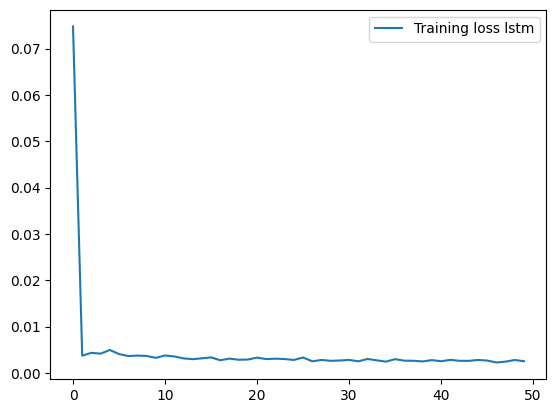

In [289]:
plt.plot(los_lstm, label="Training loss lstm")
plt.legend()
plt.show()

In [18]:
'''load the model and denormalize the data '''
model.eval()
model.load_state_dict(torch.load('./BEST/best_model_lstm_pro_prova.pth', map_location=torch.device('cpu')))

normalized_dataset_s = normalized_dataset[-974:]
X_test_tensor = torch.tensor(X_test_l, dtype=torch.float32).to(device)
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor).to(device)
y_pred_np = y_pred_tensor.cpu().detach().numpy()

normalized_df = pd.DataFrame(normalized_dataset_s, columns=['Open',	'High',	'Low','Close','Adj Close','Volume','RSI','EMAS','TargetNextClose'])

df_original = pd.DataFrame(scaler_lstm.inverse_transform(normalized_df), columns=normalized_df.columns)
label=df_original['TargetNextClose']
normalized_df['TargetNextClose'] = y_pred_np
df_original = pd.DataFrame(scaler_lstm.inverse_transform(normalized_df), columns=normalized_df.columns)
pred=df_original['TargetNextClose']

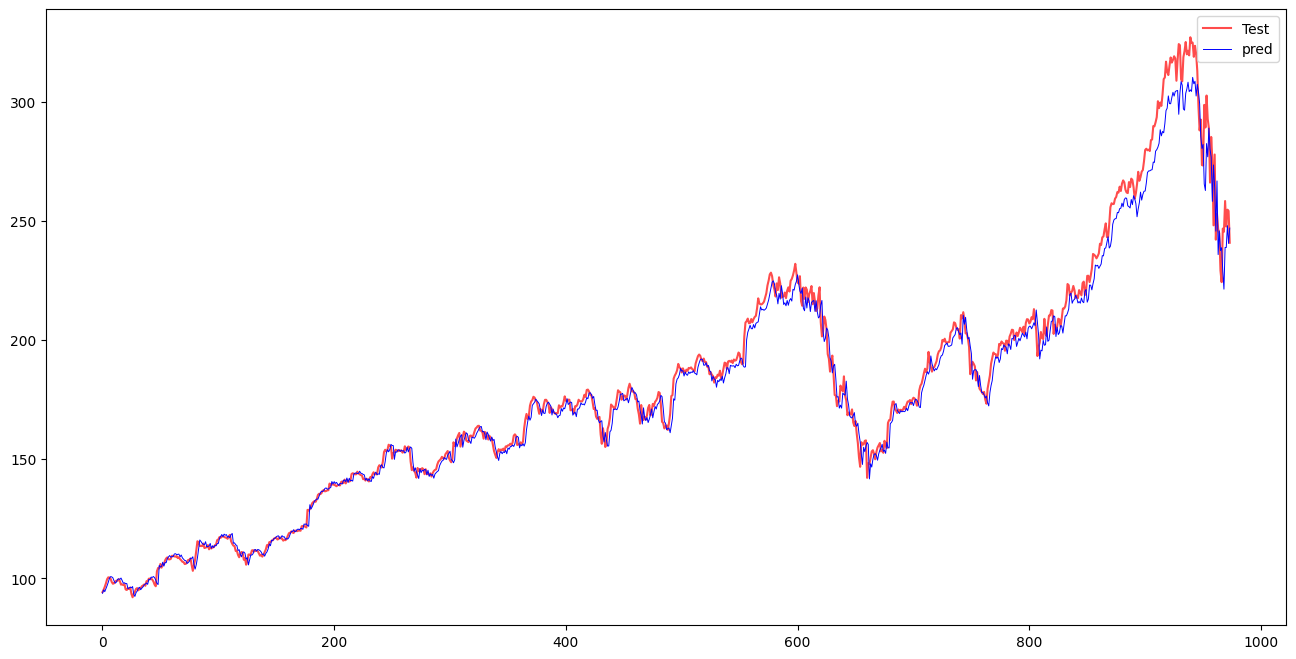

In [19]:
plt.figure(figsize=(16,8))
plt.plot(label, color='red', alpha=0.7, label = 'Test')
plt.plot(pred, color='blue', linewidth=0.7, label = 'pred')
plt.legend()
plt.show()

# Transformer

In [50]:
'''scale the data with diff and apply log to Close'''
output_window = 1 # number of prediction steps
batch_size = 250

close = np.array(apple_df['Close'])
log=np.log(close)
diff = np.diff(log, prepend=0) # Transform closing price to log returns, instead of using min-max scaler

In [52]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

In [53]:
class TransAm(nn.Module):
    def __init__(self, feature_size=250, num_layers=1, dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'

        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [54]:
def create_inout_sequences(input_data, tw):
    '''create the sequence to put into the model'''
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
    return torch.FloatTensor(inout_seq)

In [55]:
def get_data(data, split):
    '''Split ratio of training data and apply the cumsum'''

    series = data

    split = round(split*len(series))
    train_data = series[:split]
    test_data = series[split:]

    train_data = train_data.cumsum()
    train_data = 2*train_data # Training data augmentation, increase amplitude for the model to better generalize.

    test_data = test_data.cumsum()
    c=np.exp(train_data/2)

    train_sequence = create_inout_sequences(train_data,lookback)
    train_sequence = train_sequence[:-output_window]

    test_data = create_inout_sequences(test_data,lookback)
    test_data = test_data[:-output_window]
    return train_sequence.to(device), test_data.to(device), train_data[len(c)-1]/2

In [56]:
def get_batch(source, i, batch_size):
    ''' create the batches '''
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(lookback, 1))
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(lookback, 1))
    return input, target

In [57]:
train_data, val_data, c  = get_data(diff, 0.9) # 90% train, 10% test split
model_transformer = TransAm().to(device)
criterion = nn.MSELoss() # Loss function
lr = 0.00005 # learning rate

optimizer = torch.optim.AdamW(model_transformer.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

epochs =  350 # Number of epochs

c:\Users\fabio\anaconda3\envs\env\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [58]:
def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = eval_model(data)
            total_loss += len(data[0])* criterion(output, targets).cpu().item()
    return total_loss / len(data_source)

In [59]:
def forecast_seq(model, sequences):
    """Sequences data has to been windowed and passed through device"""
    start_timer = time.time()
    model_transformer.eval()
    forecast_seq = torch.Tensor(0)
    actual = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(sequences) - 1):
            data, target = get_batch(sequences, i, 1)
            output = model_transformer(data)
            forecast_seq = torch.cat((forecast_seq, output[-1].view(-1).cpu()), 0)
            actual = torch.cat((actual, target[-1].view(-1).cpu()), 0)
    timed = time.time()-start_timer
    print(f"{timed} sec")

    return forecast_seq, actual

In [318]:
los_transformer = np.zeros(epochs+1)
model_transformer.train() # Turn on the evaluation mode

start_time = time.time()
best_loss=100
for epoch in range(1, epochs + 1):
    total_loss = 0
    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        output = model_transformer(data)
        loss = criterion(output, targets)
        total_loss += loss.item()

        los_transformer[epoch] = total_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_transformer.parameters(), 0.7)
        optimizer.step()
        if total_loss < best_loss:
            best_loss = total_loss
            torch.save(model_transformer.state_dict(), './best_model_transformer_prova.pth')
            print(f'Saved the model of epoch {epoch + 1}, with Loss: {total_loss}')
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('epoch {:3d} \t {:5d}/{:5d} batches \t lr {:02.10f} \t {:5.2f} ms \t loss {:5.7f}'.format(epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0], elapsed * 1000 / log_interval, cur_loss))
            total_loss = 0
            start_time = time.time()
    scheduler.step()

Saved the model of epoch 2, with Loss: 3.674063205718994


c:\Users\fabio\anaconda3\envs\env\Lib\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


epoch   1 	     7/   35 batches 	 lr 0.0000500000 	 886.91 ms 	 loss 0.7813841
Saved the model of epoch 2, with Loss: 0.15439748764038086
epoch   1 	    14/   35 batches 	 lr 0.0000500000 	 932.31 ms 	 loss 0.3088895
epoch   1 	    21/   35 batches 	 lr 0.0000500000 	 582.16 ms 	 loss 0.5203102
Saved the model of epoch 2, with Loss: 0.08789169788360596
epoch   1 	    28/   35 batches 	 lr 0.0000500000 	 580.88 ms 	 loss 5.5458996
epoch   1 	    35/   35 batches 	 lr 0.0000500000 	 478.01 ms 	 loss 10.2548876
epoch   2 	     7/   35 batches 	 lr 0.0000451250 	 616.21 ms 	 loss 13.5065861
epoch   2 	    14/   35 batches 	 lr 0.0000451250 	 541.27 ms 	 loss 23.6285259
epoch   2 	    21/   35 batches 	 lr 0.0000451250 	 560.50 ms 	 loss 4.7132462
epoch   2 	    28/   35 batches 	 lr 0.0000451250 	 534.43 ms 	 loss 3.7175847
epoch   2 	    35/   35 batches 	 lr 0.0000451250 	 489.69 ms 	 loss 21.5256348
epoch   3 	     7/   35 batches 	 lr 0.0000428687 	 607.38 ms 	 loss 1.2335639
epoch   3

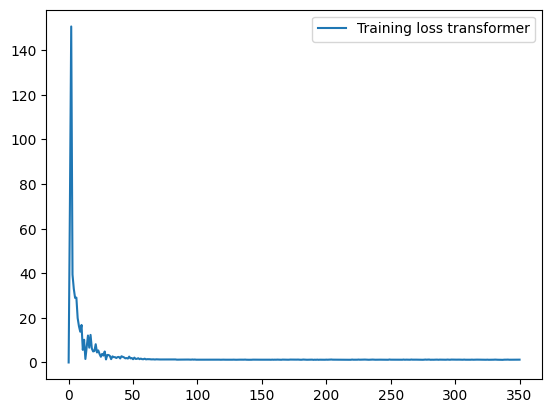

In [326]:
plt.plot(los_transformer, label="Training loss transformer")
plt.legend()
plt.show()

2.6529111862182617 sec


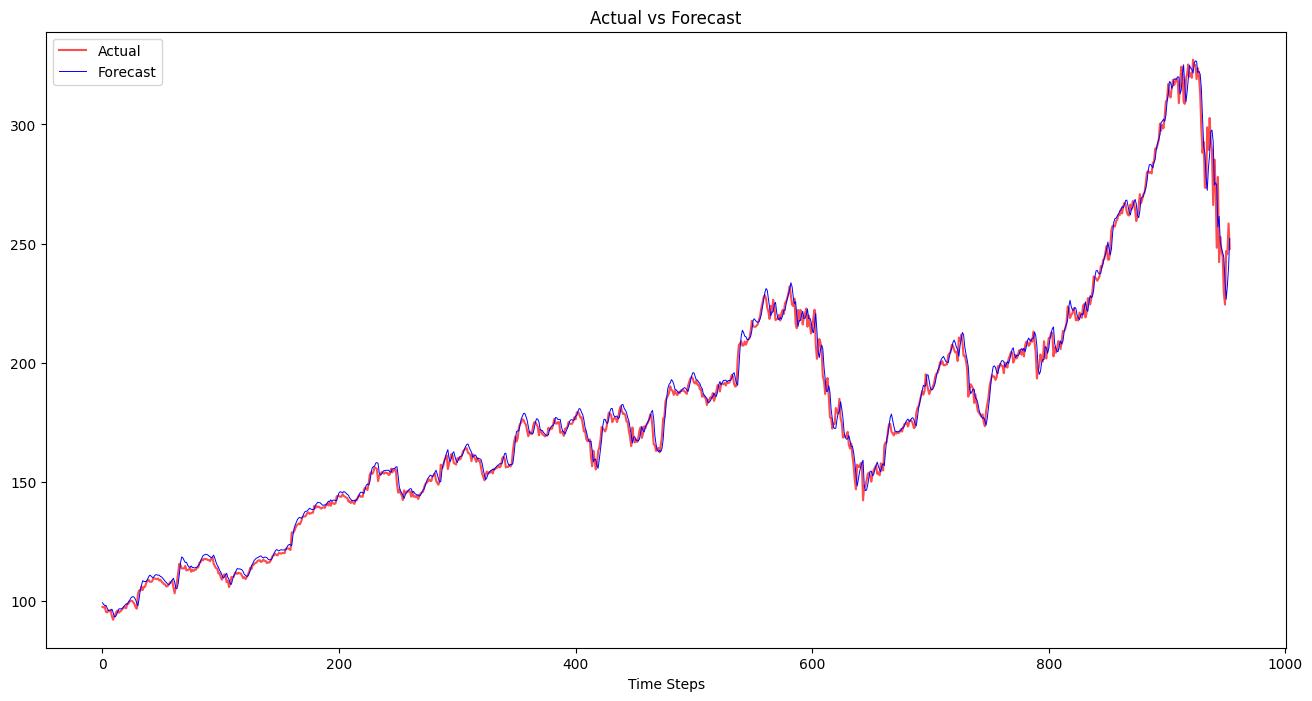

In [60]:
model_transformer.load_state_dict(torch.load('./BEST/best_model_transformer_Func.pth', map_location=torch.device('cpu')))
test_result, truth = forecast_seq(model_transformer, val_data)

actual=np.exp(truth+c)
test_result=np.exp(test_result+c)


plt.figure(figsize=(16,8))
plt.plot(actual, color='red', alpha=0.7)
plt.plot(test_result, color='blue', linewidth=0.7)
plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Forecast'])
plt.xlabel('Time Steps')
plt.show()

In [31]:
'''calculate the mean squared error and mean absolute error to compare the models'''
mse = mean_squared_error(true, p)
mae = mean_absolute_error(true, p)
print(f'Mean Squared Error Base Case: {mse}')
print(f'Mean Absolute Error Base Case: {mae}')
print("\n")

mse = mean_squared_error(y_test, y_test_pred_np)
mae = mean_absolute_error(y_test, y_test_pred_np)
print(f'Mean Squared Error LSTM: {mse}')
print(f'Mean Absolute Error LSTM: {mae}')
print("\n")

mse = mean_squared_error(label, pred)
mae = mean_absolute_error(label, pred)
print(f'Mean Squared Error LSTM Pro: {mse}')
print(f'Mean Absolute Error LSTM Pro: {mae}')
print("\n")

mse = mean_squared_error(actual, test_result)
mae = mean_absolute_error(actual, test_result)
print(f'Mean Squared Error TRANSFORMER: {mse}')
print(f'Mean Absolute Error TRANSFORMER: {mae}')
print("\n")

Mean Squared Error Base Case: 87.92025901244996
Mean Absolute Error Base Case: 6.757737876542873


Mean Squared Error LSTM: 22.320049878589057
Mean Absolute Error LSTM: 3.137224580389429


Mean Squared Error LSTM Pro: 36.39076639627796
Mean Absolute Error LSTM Pro: 3.994960803113336


Mean Squared Error TRANSFORMER: 16.06473159790039
Mean Absolute Error TRANSFORMER: 2.6180355548858643




# TESLA Stock

In [32]:
TSLA = pd.read_csv('./TSLA.csv')
print("Tesla DataFrame:")
print(TSLA.head())

Tesla DataFrame:
         Date   Open   High    Low  Close  Adj Close    Volume
0  2010-06-29  3.800  5.000  3.508  4.778      4.778  93831500
1  2010-06-30  5.158  6.084  4.660  4.766      4.766  85935500
2  2010-07-01  5.000  5.184  4.054  4.392      4.392  41094000
3  2010-07-02  4.600  4.620  3.742  3.840      3.840  25699000
4  2010-07-06  4.000  4.000  3.166  3.222      3.222  34334500


In [33]:
TSLA.dropna(inplace=True)
TSLA.reset_index(inplace = True)
datasetT = TSLA.iloc[:, 2:11]
pd.set_option('display.max_columns', None)
datasetT.head()

,Open,High,Low,Close,Adj Close,Volume
0,3.800,5.000,3.508,4.778,4.778,93831500
1,5.158,6.084,4.660,4.766,4.766,85935500
2,5.000,5.184,4.054,4.392,4.392,41094000
3,4.600,4.620,3.742,3.840,3.840,25699000
4,4.000,4.000,3.166,3.222,3.222,34334500


In [34]:
priceT = datasetT[['Close']]
scalerT = MinMaxScaler(feature_range=(-1, 1))
priceT['Close'] = scalerT.fit_transform(priceT['Close'].values.reshape(-1,1))

C:\Users\fabio\AppData\Local\Temp\ipykernel_22380\92325103.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  priceT['Close'] = scalerT.fit_transform(priceT['Close'].values.reshape(-1,1))


# Base Line

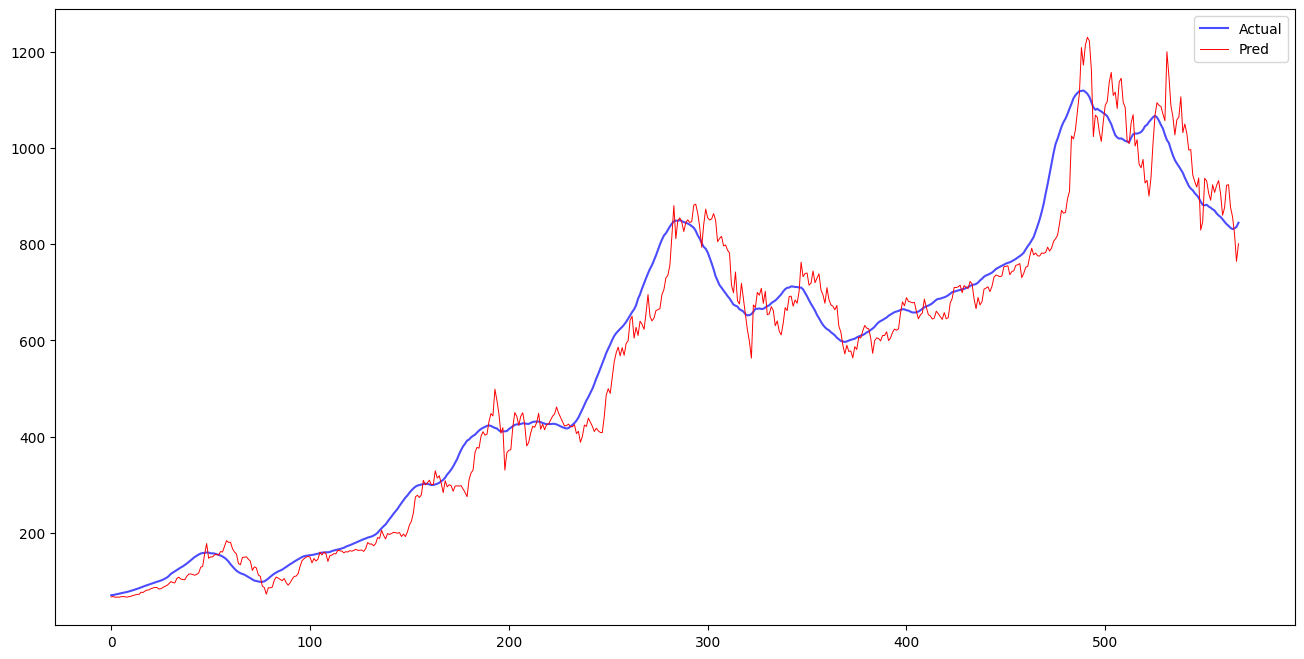

In [90]:
x_train, y_train, x_test, y_test = split_data(priceT, lookback)
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

r=[]

result = moving_average(x_test, lookback)
for i in range(len(result)):
  r.append(result[i][18])

last_values = y_test_lstm[-977:]

pT = scalerT.inverse_transform(last_values)
pT=pT[:568]
trueT = scalerT.inverse_transform(r)

plt.figure(figsize=(16,8))
plt.plot(trueT, color='blue', alpha=0.7, label = 'Actual')
plt.plot(pT, color='red', linewidth=0.7, label = 'Pred')
plt.legend()
plt.show()

# LSTM

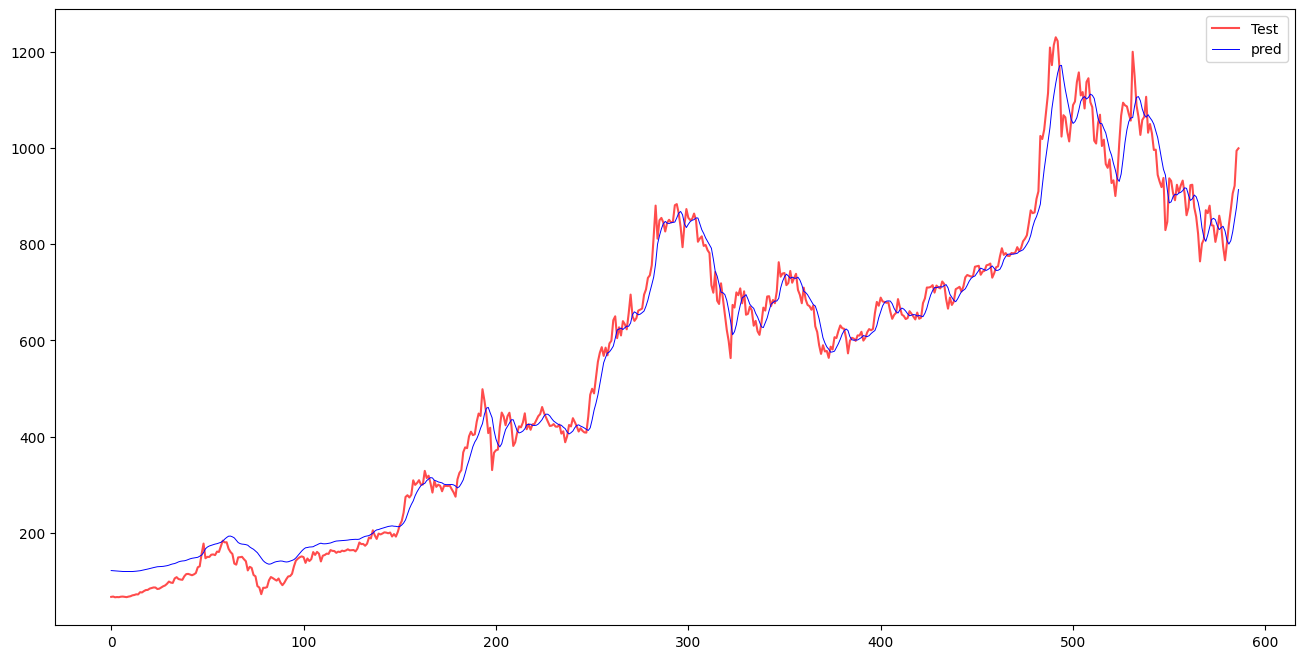

In [99]:
model_lstm.load_state_dict(torch.load('./BEST/best_model_lstm.pth', map_location=torch.device('cpu')))
model_lstm.eval()
y_test_predT = model_lstm(x_test)
y_test_pred_npT = y_test_predT.detach().numpy()
y_test_pred_npT = scalerT.inverse_transform(y_test_pred_npT)
y_test = scalerT.inverse_transform(y_test)

plt.figure(figsize=(16,8))
plt.plot(y_test, color='red', alpha=0.7, label = 'Test')
plt.plot(y_test_pred_npT, color='blue', linewidth=0.7, label = 'pred')
plt.legend()
plt.show()

# Transformer

1.8610265254974365 sec


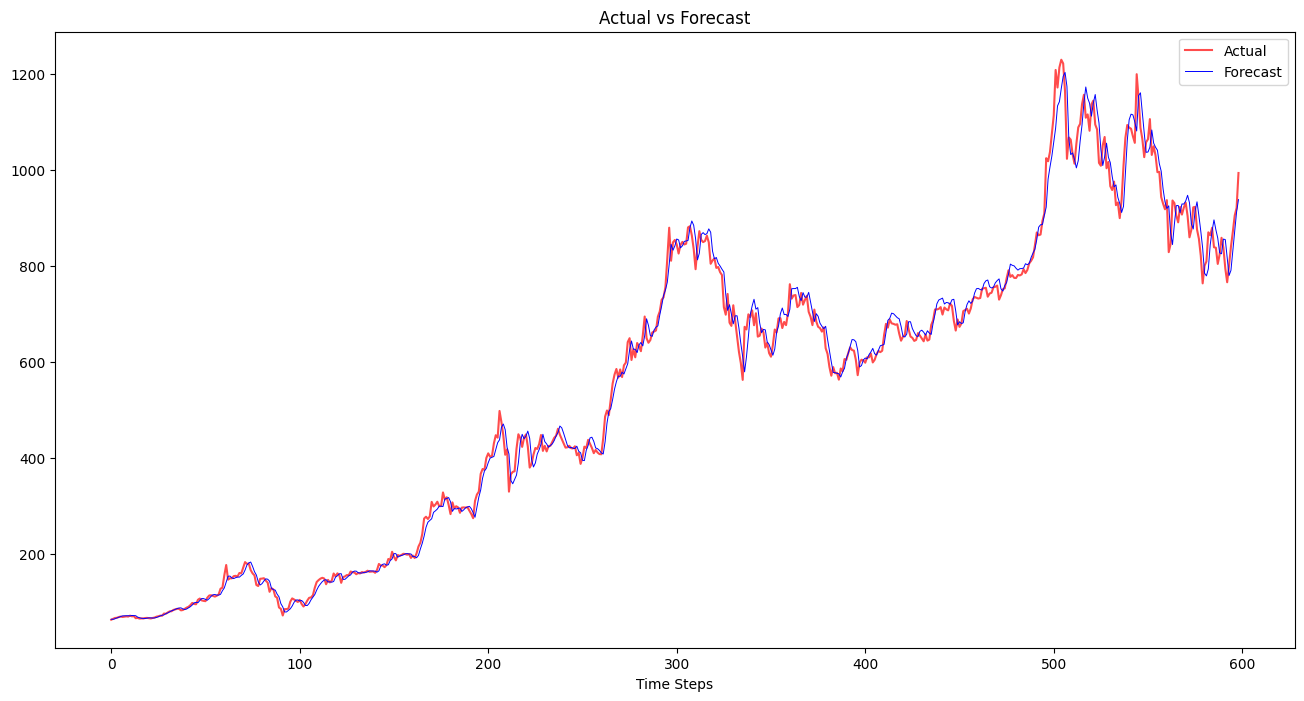

In [96]:
closeT = np.array(TSLA['Close'])
logT=np.log(closeT)
diffT = np.diff(logT, prepend=0) # Transform closing price to log returns, instead of using min-max scaler
train_data, val_data, c  = get_data(diffT, 0.79)

model_transformer.load_state_dict(torch.load('./BEST/best_model_transformer_Func.pth', map_location=torch.device('cpu')))
test_result, truth = forecast_seq(model_transformer, val_data)

actual=np.exp(truth+c)
test_result=np.exp(test_result+c)


plt.figure(figsize=(16,8))
plt.plot(actual, color='red', alpha=0.7)
plt.plot(test_result, color='blue', linewidth=0.7)
plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Forecast'])
plt.xlabel('Time Steps')
plt.show()

In [100]:
mse = mean_squared_error(trueT, pT)
mae = mean_absolute_error(trueT, pT)
print(f'Mean Squared Error Base Case: {mse}')
print(f'Mean Absolute Error Base Case: {mae}')
print("\n")

mse = mean_squared_error(y_test, y_test_pred_npT)
mae = mean_absolute_error(y_test, y_test_pred_npT)
print(f'Mean Squared Error LSTM: {mse}')
print(f'Mean Absolute Error LSTM: {mae}')
print("\n")

mse = mean_squared_error(actual, test_result)
mae = mean_absolute_error(actual, test_result)
print(f'Mean Squared Error TRANSFORMER: {mse}')
print(f'Mean Absolute Error TRANSFORMER: {mae}')
print("\n")

Mean Squared Error Base Case: 3113.9570146518713
Mean Absolute Error Base Case: 40.600650724679184


Mean Squared Error LSTM: 1463.298832934027
Mean Absolute Error LSTM: 28.98019548025497


Mean Squared Error TRANSFORMER: 764.1781005859375
Mean Absolute Error TRANSFORMER: 18.77108383178711


